In [30]:
# try
import sys

import pandas as pd # type: ignore
import numpy as np # type: ignore

import matplotlib.pyplot as plt # type: ignore
plt.style.use('ggplot')
import seaborn as sns # type: ignore

import networkx as nx # type: ignore
import graphviz # type: ignore

import statsmodels.formula.api as smf # type: ignore
from sklearn.neighbors import NearestNeighbors

from dowhy import CausalModel, gcm # type: ignore

from sklearn.neighbors import NearestNeighbors # type: ignore


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [31]:
def check_for_dataset_balance(control_idx, treatment_idx, estimate_type):

    if estimate_type == 'att':
        control_df = control.iloc[control_idx][covariates]
        treatment_df = treated.loc[treatment_idx][covariates]
        control_df['is_treatment'] = 0
        treatment_df['is_treatment'] = 1
        matched_df = pd.concat([control_df, treatment_df])
        return matched_df.groupby('is_treatment').describe().T
    elif estimate_type == 'atc':
        control_df = control.loc[control_idx][covariates]
        treatment_df = treated.iloc[treatment_idx][covariates]
        control_df['is_treatment'] = 0
        treatment_df['is_treatment'] = 1
        matched_df = pd.concat([control_df, treatment_df])
        return matched_df.groupby('is_treatment').describe().T
        

In [32]:
df = pd.read_csv("../data/processed/data.csv")
df.shape

In [33]:
nodes_list = ['Rating', 'product_category_name_encoded', 'freight_value', 'distance_km', 'month', 'is_delivery_late']
df[nodes_list].isnull().sum().sum()

np.int64(0)

In [34]:
df[nodes_list].head()

,Rating,product_category_name_encoded,freight_value,distance_km,month,is_delivery_late
0,5.0,31,21.02,687.434185,9,0
1,5.0,31,21.02,714.295670,10,0
2,1.0,31,21.02,417.139650,10,0
3,4.0,40,14.87,523.615247,2,0
4,4.0,40,14.87,523.615247,2,0


# Delayed Delieveries -> Ratings

In [35]:
# Define covariates, treatment, and outcome
covariates = ['product_category_name_encoded', 'month', 'product_size', 'freight_value', 'distance_km']
treatment = 'is_delivery_late'
outcome = 'Rating'

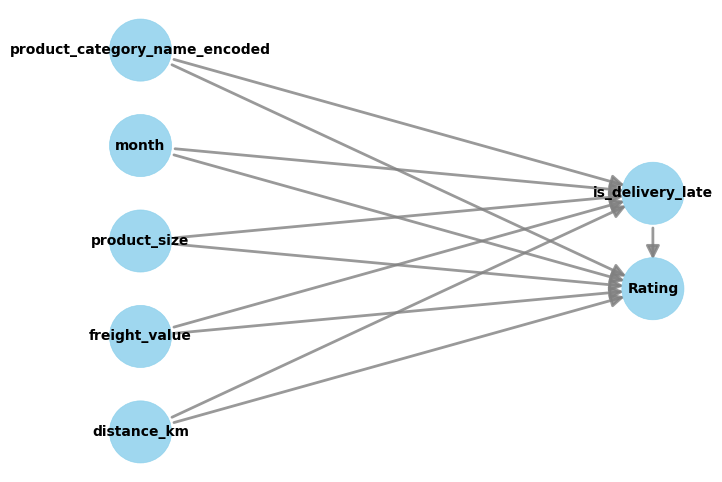

In [36]:
# Step 1: Build the causal model
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=covariates
)

# Step 2: View the graphical model 
model.view_model()

In [37]:
# Step 3: Identify the causal effect
identified_estimand = model.identify_effect()

In [38]:
# Step 4: Estimate the treatment effect using propensity score matching
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="ate"
)

**Estimating ATT**

In [39]:
# Treated and Control groups
treated = df.loc[df['is_delivery_late'] == 1]
control = df.loc[df['is_delivery_late'] == 0]

# Fitting a NN algorith on the control propensity score
control_neighbors = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(
    control['propensity_score'].values.reshape(-1, 1)
)

# Finding a match for each treated order
distances, indices = control_neighbors.kneighbors(treated['propensity_score'].values.reshape(-1, 1))

att = 0
outcome_variable = 'Rating'
treated_outcomes = treated[outcome_variable]
control_outcomes = list(control.iloc[indices.flatten()][outcome_variable])

att = (treated_outcomes - control_outcomes).mean()
print("att: ", att)

att:  -1.9906351791530945


**Checking for Balancing in the matched dataset**

In [40]:
def checking_balanced_dataset(df: pd.DataFrame, treatment: str, covariates: list[str]):
    lst = []
    for cov in covariates:
        t = df[df[treatment] == 1][cov]
        c = df[df[treatment] == 0][cov]
        # Calculate means and pooled standard deviation
        mean_treated = t.mean()
        mean_control = c.mean()
        pooled_std = np.sqrt((t.var() + c.var()) / 2)

        z = (mean_treated - mean_control) / pooled_std
        lst.append(z)
    return lst

In [41]:
control_df = control.iloc[indices.flatten()][covariates]
treatment_df = treated.loc[treated.index][covariates]
control_df['is_treatment'] = 0
treatment_df['is_treatment'] = 1
matched_df = pd.concat([control_df, treatment_df])

before_matching_covariates = checking_balanced_dataset(df, 'is_delivery_late', covariates)
after_matching_covariates = checking_balanced_dataset(matched_df, 'is_treatment', covariates)


Covariate Balance Plot

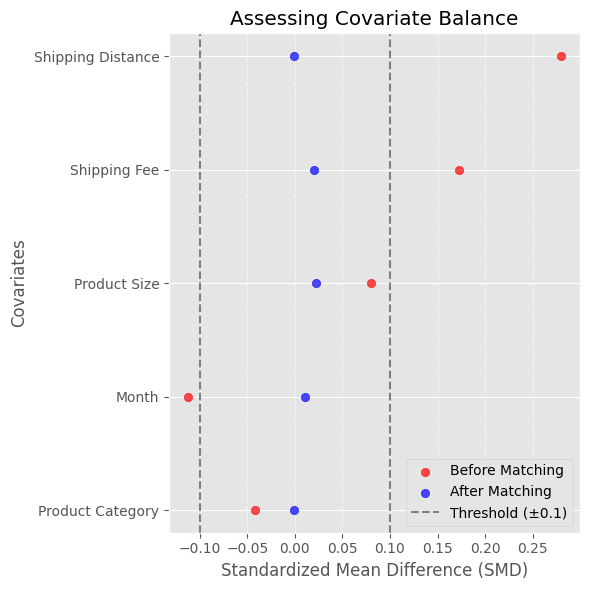

In [42]:
covariates_plot_lst = ['Product Category', 'Month', 'Product Size', 'Shipping Fee', 'Shipping Distance']
plot_df = pd.DataFrame({'covariates': covariates_plot_lst, 'smd_before': before_matching_covariates, 'smd_after': after_matching_covariates})

# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(plot_df['smd_before'], plot_df['covariates'], color='red', label='Before Matching', alpha=0.7)
plt.scatter(plot_df['smd_after'], plot_df['covariates'], color='blue', label='After Matching', alpha=0.7)
plt.axvline(x=0.1, color='gray', linestyle='--', label='Threshold (±0.1)')
plt.axvline(x=-0.1, color='gray', linestyle='--')
plt.xlabel('Standardized Mean Difference (SMD)')
plt.ylabel('Covariates')
plt.title('Assessing Covariate Balance')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Estimating ATC**

In [43]:
# Estimating ATC
treated = df.loc[df['is_delivery_late'] == 1]
control = df.loc[df['is_delivery_late'] == 0]

treated_neighbors = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(
    treated['propensity_score'].values.reshape(-1, 1)
)
distances, indices = treated_neighbors.kneighbors(control['propensity_score'].values.reshape(-1, 1))

atc = 0
outcome_variable = 'Rating'
control_outcomes = control[outcome_variable]
treated_outcomes = list(treated.iloc[indices.flatten()][outcome_variable])

atc = (treated_outcomes - control_outcomes).mean()

print("ATC: ", atc)

ATC:  -1.895936653857248


**Estimating ATE**

In [44]:
numtreatedunits = treated.shape[0]
numcontrolunits = control.shape[0]
est = (att * numtreatedunits + atc * numcontrolunits) / (numtreatedunits + numcontrolunits)
print("ATE: ", est)

ATE:  -1.9020123475065525


ATE (Average Treatment Effect)

In [45]:
# Step 5: View the results
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                     ↪
───────────────────(E[Rating|product_category_name_encoded,month,freight_value ↪
d[is_delivery_late]                                                            ↪

↪                            
↪ ,product_size,distance_km])
↪                            
Estimand assumption 1, Unconfoundedness: If U→{is_delivery_late} and U→Rating then P(Rating|is_delivery_late,product_category_name_encoded,month,freight_value,product_size,distance_km,U) = P(Rating|is_delivery_late,product_category_name_encoded,month,freight_value,product_size,distance_km)

## Realized estimand
b: Rating~is_delivery_late+product_category_name_encoded+month+freight_value+product_size+distance_km
Target units: ate

## Estimate
Mean value: -1.9020123475065525



# Bootstrap Propensity Score Matching

**Bootstrap Propensity Score Matching**

In [36]:
number_of_bootstraps = 1000
number_of_samples = 20000
att_lst = []

for i in range(number_of_bootstraps):

    df_sample = df.sample(n=number_of_samples)
    # Treated and Control groups
    treated = df_sample.loc[df['is_delivery_late'] == 1]
    control = df_sample.loc[df['is_delivery_late'] == 0]

    # Fitting a NN algorith on the control propensity score
    control_neighbors = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(
        control['propensity_score'].values.reshape(-1, 1)
    )

    # Finding a match for each treated order
    distances, indices = control_neighbors.kneighbors(treated['propensity_score'].values.reshape(-1, 1))

    att = 0
    outcome_variable = 'Rating'
    treated_outcomes = treated[outcome_variable]
    control_outcomes = list(control.iloc[indices.flatten()][outcome_variable])

    att = (treated_outcomes - control_outcomes).mean()

    att_lst.append(att)
    

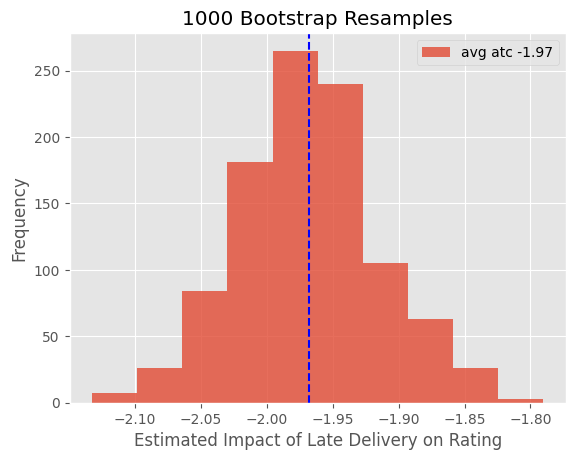

In [37]:
plt.hist(att_lst, alpha=0.8, label=f'avg atc {round(np.mean(att_lst),2)}')
plt.axvline(np.mean(att_lst), ls='--', c='blue')
plt.xlabel("Estimated Impact of Late Delivery on Rating")
plt.ylabel("Frequency")
plt.title("1000 Bootstrap Resamples")
plt.legend();

In [ ]:
lower_bound = np.percentile(att_lst, 2.5)
upper_bound = np.percentile(att_lst, 97.5)
lower_bound, upper_bound

-----

**Resources:**


- Bootstrap Propensity Score Matching: https://arxiv.org/html/2408.05297v1


